In [144]:

# Import Required Modules
from flask import Flask, render_template
import pandas as pd
import json
import plotly
import plotly.express as px
import pandas_ta as pta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import date
from datetime import timedelta, date
from prophet import Prophet
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt



# Create Home Page Route
app = Flask(__name__)




df = pd.read_csv("Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.Ticker('BTC-USD').history(period='7y',interval='1d',actions=False).reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Unnamed: 0', "wallets", "address", "mined"])
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
df['7D'] = df['price'].rolling(7).mean()
# df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
# df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = (df['price-meanavge']/(df['price'] + df['meanavge']))
bins = [-.43, -.18, 0, .18, .43]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)

k = df['price'].ewm(span=12, adjust=False, min_periods=12).mean()

# Get the 12-day EMA of the closing price
d = df['price'].ewm(span=26, adjust=False, min_periods=26).mean()

# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)


df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = date.today() + timedelta(days=60)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)


# Buy Zones
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(height=500, width=1000)
fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")

Buyzones = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                title="price")
fig.add_trace(go.Scatter(name="200D", x=df['date'], y=df['200D'], marker = {'color' : 'red'}, legendrank=2))
fig.add_trace(go.Scatter(name="MeanAverage", x=df['date'], y=df['meanavge'], marker = {'color' : 'purple'}, legendrank=2))
fig.add_trace(go.Scatter(name="50D", x=df['date'], y=df['50D'], marker = {'color' : 'blue'}, legendrank=2))
fig.add_trace(go.Scatter(name="300D", x=df['date'], y=df['300D'], marker = {'color' : 'black'}, legendrank=2))

# Moving Averages
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Moving Averages')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(margin=dict(l=20, r=100, t=70, b=20))
fig.update_layout(height=500, width=1000)
fig.update_layout(showlegend=True)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")

Movingaverages = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

# MACD

# df.fillna(0, inplace=True)
df_tail = df.tail(360)
df_tail.head()

df_tail['RSI'] = pta.rsi(df['price'], length = 14)

fig = make_subplots(rows=3, cols=1,shared_xaxes=True,vertical_spacing=0.001, row_heights=[0.2, 0.2,0.09])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

# fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
# 					marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
# 			3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=3, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=700, width=1000, title_text="720 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
	
 

22:02:02 - cmdstanpy - INFO - Chain [1] start processing
22:02:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\16474\AppData\Local\Temp\ipykernel_3660\3123807796.py:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [145]:

df['RSI'] = pta.rsi(df['price'], length = 14)

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.00001, row_heights=[0.2,0.2])

fig.add_trace(
    go.Scatter(name="Price",x=df['date'], y=df['price'],
        marker=dict(color=df['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Scatter(name="RSI",x=df['date'], y=df['RSI'],
    marker=dict(color=df['RSI'], coloraxis="coloraxis3")),
    row=2, col=1)



fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
# fig.update_yaxes(type="log", row=1, col=1)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=700, width=1000, title_text="720 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()

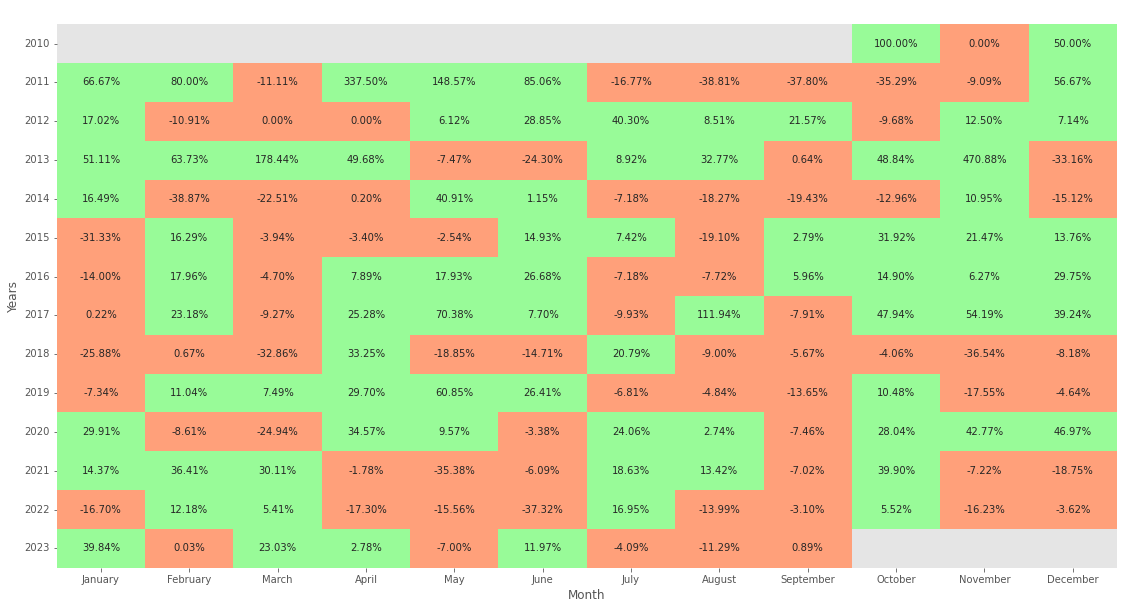

In [146]:
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import colors


df["month"] = df["date"].dt.strftime('%Y-%m')

# Compute the monthly returns
df_monthly = df.groupby("month")["price"].last().pct_change()

# Convert the resulting Series to a DataFrame
df_returns = df_monthly.to_frame(name="returns")

# Use pivot_table to reshape the data by year and month
df_pivot = df_returns.pivot_table(index=df_returns.index.str.slice(0,4),
                                  columns=df_returns.index.str.slice(5,),
                                  values="returns")

# import pandas as pd
df_pivot.rename(columns={'01': 'January', 
                          '02': 'February', 
                          '03': 'March', 
                          '04': 'April', 
                          '05': 'May', 
                          '06': 'June', 
                          '07': 'July', 
                          '08': 'August', 
                          '09': 'September', 
                          '10': 'October', 
                          '11': 'November', 
                          '12': 'December'}, inplace=True)
# Create a heatmap using Seaborn

lighter_red = '#FFA07A'
lighter_green = '#98FB98'

heatmap = sns.heatmap(df_pivot, cmap=[lighter_red, lighter_green], cbar=False, annot=True, fmt=".2%", center=0)
heatmap.tick_params(axis='x', rotation=0)

# Get the current tick locations and labels of the x-axis
x_ticks = heatmap.get_xticks()

# Create a list of all the unique x values in the pivot table
x_values = df_pivot.columns.get_level_values(0)

# Set the label for the x-axis of the heatmap
heatmap.set_xlabel('Month')
heatmap.set_ylabel('Years')

# change the figure size
fig = heatmap.get_figure()
fig.set_size_inches(19,10) # adjust the width and height as per your preference
# Set the tick labels for the x-axis
heatmap.set_xticklabels(x_values)

# Add a title to the heatmap
heatmap.set_title("Bitcoin Returns by Month")
# Show the plot
heatmap.figure.savefig("static/heatmap.png")
plt.show()


In [147]:
df

,date,price,Volume,200D,300D,50D,7D,meanavge,meanvalue,status,price-meanavge,move%,Valuation,macd,macd_h,macd_s,priceL,RSI,month
0,2010-09-25,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,-2.302585,NaN,2010-09
1,2010-09-26,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,-2.302585,NaN,2010-09
2,2010-09-27,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,-2.302585,NaN,2010-09
3,2010-09-28,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,-2.302585,NaN,2010-09
4,2010-09-29,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,-2.302585,NaN,2010-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4711,2023-09-16,26568.281250,7.402031e+09,27703.716172,25036.447646,27341.967305,26110.456752,26694.043708,-125.762458,0,-125.762458,-0.002361,Neutral Oversold,-236.600124,183.945540,-420.545664,10.187473,51.445364,2023-09
4712,2023-09-17,26534.187500,6.774211e+09,27718.154355,25072.270658,27285.512695,26210.736886,26691.979236,-157.791736,0,-157.791736,-0.002965,Neutral Oversold,-191.932011,182.890923,-374.822933,10.186189,50.988382,2023-09
4713,2023-09-18,26754.281250,1.561534e+10,27734.548428,25107.485697,27235.092148,26438.112165,26692.375424,61.905826,1,61.905826,0.001158,Neutral Overbought,-137.191030,190.105523,-327.296553,10.194450,53.839043,2023-09
4714,2023-09-19,27211.117188,1.380769e+10,27758.790615,25142.820397,27194.712266,26634.936942,26698.774426,512.342762,1,512.342762,0.009504,Neutral Overbought,-56.296613,216.799951,-273.096565,10.211381,59.150031,2023-09


In [148]:
import plotly.graph_objects as go

import pandas as pd


# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(df.date), y=list(df.price)))

# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

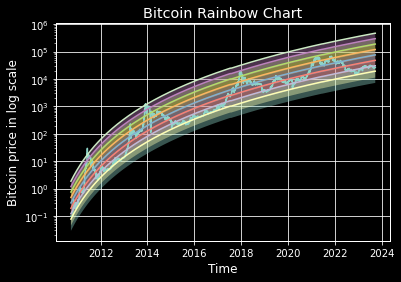

In [149]:
'''
Created on 15 Feb 2022
@author: TotesMcGoats
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# This data was gotten on https://data.nasdaq.com/, you need an account to download it, but you have 50 free API calls per day and unlimited if you sign up, which is free.
raw_data =  pd.DataFrame(df).reset_index()

# Rename the 'date' column to 'Date' and the 'price' column to 'Value'
raw_data = raw_data.rename(columns={'date': 'Date', 'price': 'Value'})

raw_data['Date'] = pd.to_datetime(raw_data['Date']) # Ensure that the date is in datetime or graphs might look funny
raw_data = raw_data[raw_data["Value"] > 0] # Drop all 0 values as they will fuck up the regression bands

# this is your log function
def logFunc(x,a,b,c):
    return a*np.log(b+x) + c

# getting your x and y data from the dataframe
xdata = np.array([x+1 for x in range(len(raw_data))])
ydata = np.log(raw_data["Value"])

# here we ar fitting the curve, you can use 2 data points however I wasn't able to get a graph that looked as good with just 2 points.
popt, pcov = curve_fit(logFunc, xdata, ydata, p0 = [10,100,90]) # p0 is justa guess, doesn't matter as far as I know

# This is our fitted data, remember we will need to get the ex of it to graph it
fittedYData = logFunc(xdata, popt[0], popt[1], popt[2])

# Dark background looks nice
plt.style.use("dark_background")
# Plot in a with long Y axis
plt.semilogy(raw_data["Date"], raw_data["Value"])
plt.title('Bitcoin Rainbow Chart')
plt.xlabel('Time')
plt.ylabel('Bitcoin price in log scale')

# Draw the rainbow bands
for i in range(-2,6):
    raw_data[f"fitted_data{i}"] = np.exp(fittedYData + i*.455)
    plt.plot(raw_data["Date"], np.exp(fittedYData + i*.455))
    #You can use the below plot fill between rather than the above line plot, I prefer the line graph
    plt.fill_between(raw_data["Date"], np.exp(fittedYData + i*.45 -1), np.exp(fittedYData + i*.45), alpha=0.4)

# # Back Testing
# df = raw_data
# # Change the DCA time frame here, daily = df[::1], weekly = [::7], biweekly = [::14], monthly = [::30], yearly = df[::365]]
# buyFrequency = 30
# monthly = df[::buyFrequency].reset_index()
# # Change the date you start to DCA here
# startDate = '2019-01-01'
# monthly = monthly[monthly['Date'] > startDate]
# # Change your buy amount here
# buyAmount = 100
# totalDCA = 0
# totalRCA = 0
# amount_invested_DCA = 0
# amount_invested_RCA = 0
# fibs = {"bubble":0, "sell":0.1, "FOMO":0.2, "Bubble?":0.3, "Hodl":0.5, "cheap":0.8, "accumulate":1.3,"Buy":2.1,"fire_sale":3.4}
# originalRCA = {6:0, 5:0.1, 4:0.2, 3:0.35, 2:0.5, 1:0.75, 0:1,-1:2.5,-2:3}
# # Choose what type of weightings you want to RCA with
# weighted = fibs
# # This loop calculates what rainbow regression bands each data point for your DCA falls between.
# for x in range(0, len(monthly)):
#     # if below the first band the buy buyAmount*3.4 and so on for each successive line
#     if monthly.Value.iloc[x] < monthly["fitted_data-2"].iloc[x]:
#         print("Bitcoin is below $", monthly["fitted_data-1"].iloc[x], " therefore our multiplier is ", weighted["fire_sale"])
#         totalDCA = totalDCA + buyAmount/monthly.Value.iloc[x]
#         totalRCA = totalRCA + buyAmount * weighted["fire_sale"] / monthly.Value.iloc[x]
#         amount_invested_RCA = amount_invested_RCA + buyAmount * weighted["fire_sale"]
#         amount_invested_DCA = amount_invested_DCA + buyAmount

#     elif monthly.Value.iloc[x] > monthly["fitted_data-2"].iloc[x] and monthly.Value.iloc[x] < monthly["fitted_data-1"].iloc[x]:
#         print("Bitcoin is below $", monthly["fitted_data-1"].iloc[x], " therefore our multiplier is ", weighted["Buy"])
#         totalDCA = totalDCA + buyAmount/monthly.Value.iloc[x]
#         totalRCA = totalRCA + buyAmount * weighted["Buy"] / monthly.Value.iloc[x]
#         amount_invested_RCA = amount_invested_RCA + buyAmount * weighted["Buy"]
#         amount_invested_DCA = amount_invested_DCA + buyAmount

#     elif monthly.Value.iloc[x] > monthly["fitted_data-1"].iloc[x] and monthly.Value.iloc[x] < monthly["fitted_data0"].iloc[x]:
#         print("Bitcoins price falls between $", monthly["fitted_data-1"].iloc[x], "and $", monthly["fitted_data0"].iloc[x], " therefore our multiplier is ", weighted["accumulate"])
#         totalDCA = totalDCA + buyAmount/monthly.Value.iloc[x]
#         totalRCA = totalRCA + buyAmount * weighted["accumulate"] / monthly.Value.iloc[x]
#         amount_invested_RCA = amount_invested_RCA + buyAmount * weighted["accumulate"]
#         amount_invested_DCA = amount_invested_DCA + buyAmount


#     elif monthly.Value.iloc[x] > monthly["fitted_data0"].iloc[x] and monthly.Value.iloc[x] < monthly["fitted_data1"].iloc[x]:
#         print("Bitcoins price falls between $", monthly["fitted_data0"].iloc[x], "and $", monthly["fitted_data1"].iloc[x], " therefore our multiplier is ", weighted["cheap"])
#         totalDCA = totalDCA + buyAmount/monthly.Value.iloc[x]
#         totalRCA = totalRCA + buyAmount * weighted["cheap"] / monthly.Value.iloc[x]
#         amount_invested_RCA = amount_invested_RCA + buyAmount * weighted["cheap"]
#         amount_invested_DCA = amount_invested_DCA + buyAmount

#     elif monthly.Value.iloc[x] > monthly["fitted_data1"].iloc[x] and monthly.Value.iloc[x] < monthly["fitted_data2"].iloc[x]:
#         print("Bitcoins price falls between $", monthly["fitted_data1"].iloc[x], "and $", monthly["fitted_data2"].iloc[x], " therefore our multiplier is ", weighted["Hodl"])
#         totalDCA = totalDCA + buyAmount/monthly.Value.iloc[x]
#         totalRCA = totalRCA + buyAmount * weighted["Hodl"] / monthly.Value.iloc[x]
#         amount_invested_RCA = amount_invested_RCA + buyAmount * weighted["Hodl"]
#         amount_invested_DCA = amount_invested_DCA + buyAmount

#     elif monthly.Value.iloc[x] > monthly["fitted_data2"].iloc[x] and monthly.Value.iloc[x] < monthly["fitted_data3"].iloc[x]:
#         print("Bitcoins price falls between $", monthly["fitted_data2"].iloc[x], "and $", monthly["fitted_data3"].iloc[x], " therefore our multiplier is ", weighted["Bubble?"])
#         totalDCA = totalDCA + buyAmount/monthly.Value.iloc[x]
#         totalRCA = totalRCA + buyAmount * weighted["Bubble?"] / monthly.Value.iloc[x]
#         amount_invested_RCA = amount_invested_RCA + buyAmount * weighted["Bubble?"]
#         amount_invested_DCA = amount_invested_DCA + buyAmount

#     elif monthly.Value.iloc[x] > monthly["fitted_data3"].iloc[x] and monthly.Value.iloc[x] < monthly["fitted_data4"].iloc[x]:
#         print("Bitcoins price falls between $", monthly["fitted_data3"].iloc[x], "and $", monthly["fitted_data4"].iloc[x], " therefore our multiplier is ", weighted["FOMO"])
#         totalDCA = totalDCA + buyAmount/monthly.Value.iloc[x]
#         totalRCA = totalRCA + buyAmount * weighted["FOMO"] / monthly.Value.iloc[x]
#         amount_invested_RCA = amount_invested_RCA + buyAmount * weighted["FOMO"]
#         amount_invested_DCA = amount_invested_DCA + buyAmount

#     elif monthly.Value.iloc[x] > monthly["fitted_data4"].iloc[x] and monthly.Value.iloc[x] < monthly["fitted_data5"].iloc[x]:
#         print("Bitcoins price falls between $", monthly["fitted_data4"].iloc[x], "and $", monthly["fitted_data5"].iloc[x], " therefore our multiplier is ", weighted["sell"])
#         totalDCA = totalDCA + buyAmount/monthly.Value.iloc[x]
#         totalRCA = totalRCA + buyAmount * weighted["sell"] / monthly.Value.iloc[x]
#         amount_invested_RCA = amount_invested_RCA + buyAmount * weighted["sell"]
#         amount_invested_DCA = amount_invested_DCA + buyAmount

#     else:
#         print("Don't buy bitcoin")
#         totalDCA = totalDCA + buyAmount/monthly.Value.iloc[x]
#         totalRCA = totalRCA + buyAmount * weighted["bubble"] / monthly.Value.iloc[x]
#         amount_invested_RCA = amount_invested_RCA + buyAmount * weighted["bubble"]
#         amount_invested_DCA = amount_invested_DCA + buyAmount

# # This plots the locations of your buy points.
# plt.scatter(monthly["Date"],monthly["Value"], c="red")

# print("Total value RCA ", totalRCA)
# print("Total value DCA ", totalDCA)
# print(amount_invested_RCA)
# print(amount_invested_DCA)

# plt.show()

# print("\n")
# print("Buy Frequency: every", buyFrequency, "days")
# print("Strategy Starting Date:", startDate)
# print("Purchase Amount: $", buyAmount)

# print("\n")
# print("Color Band Multipliers:")
# for key, value in weighted.items():
#     print(key, value)

# print("\n")
# totalDCADollars = monthly.Value.iloc[len(monthly) - 1] * totalDCA
# percentGainsDCA = ((totalDCADollars / amount_invested_DCA) - 1) * 100
# print("Total Invested DCA: $", float("{:.2f}".format(amount_invested_DCA)))
# print("Total value DCA:",float("{:.4f}".format(totalDCA)), "BTC, or $", float("{:.2f}".format(totalDCADollars)))
# print("% Gains DCA:", float("{:.2f}".format(percentGainsDCA)), "%")

# print("\n")
# totalRCADollars = monthly.Value.iloc[len(monthly) - 1] * totalRCA
# percentGainsRCA = ((totalRCADollars / amount_invested_RCA) - 1) * 100
# print("Total Invested RCA: $",float("{:.2f}".format(amount_invested_RCA)))
# print("Total Value RCA:",float("{:.4f}".format(totalRCA)), "BTC, or $", float("{:.2f}".format(totalRCADollars)))
# print("% Gains RCA:", float("{:.2f}".format(percentGainsRCA)), "%")

# print("\n")
# print("RCA performance increase over DCA:", float("{:.2f}".format(((percentGainsRCA / percentGainsDCA) - 1) * 100)), "%")

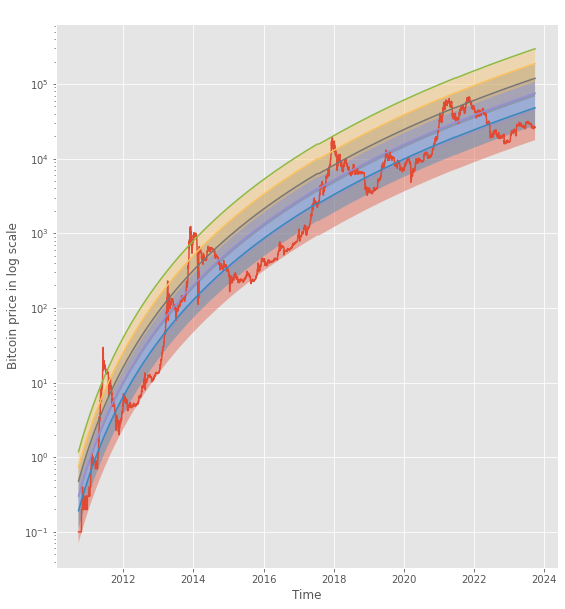

In [162]:
import matplotlib.pyplot as plt

# Set dark background theme
plt.style.use("ggplot")

# Create plot with larger size
fig, ax = plt.subplots(figsize=(9, 10))
ax.semilogy(raw_data["Date"], raw_data["Value"])
ax.set(title='Bitcoin Rainbow Chart', xlabel='Time', ylabel='Bitcoin price in log scale')

# Draw the rainbow bands
for i in range(0,5):
    raw_data[f"fitted_data{i}"] = np.exp(fittedYData + i*.455)
    ax.plot(raw_data["Date"], np.exp(fittedYData + i*.455))
    #You can use the below plot fill between rather than the above line plot, I prefer the line graph
    ax.fill_between(raw_data["Date"], np.exp(fittedYData + i*.45 -1), np.exp(fittedYData + i*.45), alpha=0.4)

# Display plot
plt.show()
